<a href="https://colab.research.google.com/github/timosachsenberg/EuBIC2025/blob/main/notebooks/EUBIC_Task2_ID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies (for Google Colab)
!pip install -q pyopenms>=3.5.0 pyopenms-viz>=1.0.0

# Notebook 2 – Peptide Database Search

Idea: We have our digest (same FASTA! In all tasks)
Calculate mass (not m/z!) of in silico peptides
Given a spectrum, which peptides match with 0.1 Da tolerance?
Use theoretical spectrum generator to calculate in-silico fragments for both
Use the SpectrumAlignment class to determine how many fragments match (PSM)
Our toy PSM score is the number of matching fragments: which is the best candidate? How many fragments match?


(for advanced students: provide full search engine as additional google colab notebook (from CPM lecture))

TODO: make nice introduction like in Task1, explain in text etc.

# Notebook 2 – Peptide Database Search
Having established a foundation in enzymatic digestion and mass-spectral visualization, we now turn to the central task of peptide identification through database search. This notebook guides the reader through the conceptual workflow that links raw MS/MS spectra to peptide identifications. Each step mirrors the core logic employed by modern search engines, but implemented transparently for conceptual purposes.

In this notebook we will:

1. **Compute monoisotopic peptide masses (theoretical masses)**  
   - Calculate the neutral monoisotopic mass for every peptide produced by in-silico digestion.


2. **Compute precursor masses for MS/MS spectra**  
   - For each MS/MS spectrum, compute the neutral precursor mass from its precursor m/z and charge.
   
These precursor masses can then be compared to theoretical peptide masses to find plausible matches.

3. **Select candidate peptides (precursor filtering)**
  - Compare each spectrum’s precursor mass to the list of theoretical peptide masses.
  - Use a precursor mass tolerance to determine which peptides are valid candidates for each spectrum.
     
4. **Generate theoretical fragment spectra**
   - For each candidate peptide, generate its theoretical fragment ion spectrum (e.g., b/y ions) for later comparison.

5. **Align observed and theoretical spectra**
    - Align each observed MS/MS spectrum with the theoretical spectrum of each candidate peptide.

6. **Score peptide–spectrum matches**
    - Evaluate the alignment by counting the number of matched fragment ions.
    - This simple scoring function serves as a basic example of peptide–spectrum scoring.

7. **Optional: Annotate spectra and visualization**
    - Produce fragment ion annotations and visualize spectra for inspected/identified matches.

In [ ]:
%matplotlib inline
import os
import pyopenms as oms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
print("pyOpenMS version:", oms.__version__)

pyOpenMS version: 3.5.0


In [ ]:
# Download fasta from course repository
if not os.path.exists("two_proteins.fasta"):
  !wget -q -O "two_proteins.fasta" https://raw.githubusercontent.com/timosachsenberg/EuBIC2025/main/data/two_proteins.fasta

# Download mzML (large file ~732MB, hosted externally)
if not os.path.exists("mzML_file.mzML"):
  !wget -O "mzML_file.mzML" https://abibuilder.cs.uni-tuebingen.de/archive/openms/Tutorials/Example_Data/ProteomicsLFQ/UPS1_50000amol_R2.mzML

In [ ]:
# step taken from previous notebook
def preprocess_database(fasta_path, min_len_pept=6, max_len_pept=30, missed_cleavages=2):
    database_entries = []
    f = oms.FASTAFile()
    f.load(fasta_path, database_entries)

    database_seqs = [
        [e.sequence, e.identifier] for e in database_entries
        if 'X' not in e.sequence # remove any protein seq contain X
    ]

    # configure protein digestion
    dig = oms.ProteaseDigestion()
    dig.setMissedCleavages(missed_cleavages)

    peptides = []
    for prot_seq, ID in database_seqs:
        # take protein sequence as AASequence
        protein = oms.AASequence.fromString(prot_seq)
        peptides_ = []
        # peptides
        dig.digest(protein, peptides_, min_len_pept, max_len_pept)
        # add results of digested sequence to possible peptides
        peptides.extend(peptides_)

    # peptide list contain AASequence objects
    return peptides

In [ ]:
# preprocess database
peptides = preprocess_database("two_proteins.fasta")
print("Total peptides after digestion: ", len(peptides))

## 1. Compute the Monoisotopic Mass of Each Peptide

**Aim of this task**
  - After protein digestion, the peptide identification workflow starts with the calculate the monoisotopic mass.
  - Calculating the monoisotopic mass of each peptide allows for filtering candidate sequences based on their mass, facilitating comparison with experimental spectra.

**Implementation**
  - The `getMonoWeight()` method from `AASequence` can be used to compute its peptde sequence monoisotopic mass.
  - checkout: [https://pyopenms.readthedocs.io/en/latest/user_guide/peptides_proteins.html](https://pyopenms.readthedocs.io/en/latest/user_guide/peptides_proteins.html)


In [ ]:
# Function to compute monoisotopic masses for a list of peptides
def get_peptide_weights(peptides):
    return [p.getMonoWeight() for p in peptides]

# calculate the monoisotopic masses of peptides
peptides_weight = get_peptide_weights(peptides)

## 2. Calculate the precursor mass of MS2 spectra

**Aim of this task**
  - After computing peptide monoisotopic masses, the next step is to determine the precursor masses from the MS2 spectra.
  - This allows identification of candidate peptides that match the experimental spectra.

**Implementation**
  - Precursor information can be extracted from each spectrum using the `getPrecursors()` method from `MSSpectrum`.
  - From the precursor object, the uncharged mass and charge can be obtained via `getUnchargedMass()` and `getCharge()`.
  - checkout: [https://pyopenms.readthedocs.io/en/latest/user_guide/ms_data.html](https://pyopenms.readthedocs.io/en/latest/user_guide/ms_data.html)


In [ ]:
# Function to extract precursor masses and charges from MS2 spectra
def get_precursor_weights(MS2):
    precursors_charge = []
    precursors_M = []

    # Iterate over each MS2 spectrum
    for spec in MS2:
        p = spec.getPrecursors()[0]
        precursors_charge.append(p.getCharge())

        # Get uncharged mass (i.e. mass without protons)
        precursors_M.append(p.getUnchargedMass())

    precursors_charge = np.array(precursors_charge)
    precursors_M = np.array(precursors_M)

    return precursors_M, precursors_charge


In [ ]:
exp = oms.MSExperiment()

# Load mzML file
oms.MzMLFile().load("mzML_file.mzML", exp)

# Define MSExperiment to store MS2 spectra only
MS2 = oms.MSExperiment()
for spec in exp:
    if spec.getMSLevel() == 2: # keep only MS2 spectra
            spec.sortByPosition() # sort the peaks in a spectrum by their m/z positions in ascending order.
            MS2.addSpectrum(spec)

# Get precursoe mass and charge of MS2 spectra
P_mass , P_charge = get_precursor_weights(MS2)
print("Number of precursors:", len(P_mass))

## 3. Identify the candidate peptide

**Aim of this task**

  - After obtaining precursor masses from the MS2 spectra and calculating monoisotopic masses for all peptides, the goal is to identify candidate peptides whose masses match the observed precursors.
  
**Implementation**

- Convert the list of peptide masses into a NumPy array to enable efficient vectorized comparison.

- For each precursor mass:

    - Use `np.close` with an absolute and optional relative tolerance to find all peptide masses within the specified matching window.

    - Retrieve the indices of matching peptides and collect the corresponding peptide sequences as candidate lists.

- Store the resulting candidate lists in a DataFrame for downstream theoretical spectrum generation.

- Add the precursor charge as an additional column, since fragment charge limits depend on it.

- Retain only spectra that have more than one distinct candidate, ensuring that the later comparison and scoring steps are meaningful.





In [ ]:
def get_candidates_per_spectrum(precusor_weights, peptide_weight, peptides, absolute_tolerance=0.1, relative_tolerance=0):
    """
    For each precursor mass, find peptides from a database whose masses are close to the precursor mass.

    Parameters:
    -----------
    precusor_weights : list or array-like
        A list/array of precursor masses (one per spectrum).
    peptide_weight : list or array-like
        Array of peptide masses corresponding to 'peptides'.
    peptides : list
        List of peptide sequences in the database.
    absolute_tolerance : float, optional
        Maximum absolute mass difference allowed (default: 0.1 Da).
    relative_tolerance : float, optional
        Maximum relative mass difference allowed (default: 0).

    Returns:
    --------
    pd.DataFrame
        DataFrame with one column 'candidates' containing lists of candidate peptides per spectrum.
    """

    # Initialize list to store candidate peptides for each spectrum
    pept_candidates = []

    # Convert peptide weights to a numpy array for efficient computation
    peptide_weights_arr = np.array(peptide_weight)

    # Iterate over each precursor mass
    for prec_weight in precusor_weights:

        # Find indices of peptides whose mass is close to the precursor mass within tolerance
        # np.isclose returns a boolean array where True indicates the match
        # np.where returns the indices of True values
        pept_indices = np.where(
            np.isclose(
                prec_weight,             # target precursor mass
                peptide_weights_arr,     # array of peptide masses to compare
                atol=absolute_tolerance, # absolute tolerance
                rtol=relative_tolerance  # relative tolerance
            )
        )[0]  # [0] extracts indices from the tuple returned by np.where

        # Retrieve the peptide sequences corresponding to the matching indices
        pept_candidates.append([peptides[i] for i in pept_indices])

    # Return a DataFrame with one row per spectrum containing the candidate peptides
    return pd.DataFrame(list(zip(pept_candidates)), columns=['candidates'])



In [ ]:
# Generate candidate peptides for each precursor
candidate_df = get_candidates_per_spectrum(precusor_weights=P_mass, peptide_weight=peptides_weight, peptides=peptides)

# Add the charge column to df
candidate_df["charge"] = P_charge

# Since our peptide pool is less, many of spectra dont find candidate
# Keep spectra which has at least two different peptide candidates for later analysis
candidate_df = candidate_df[
    candidate_df["candidates"].apply(lambda x: len(set(x)) > 1)
]

# Keep just one spectra for simplicity of task
candidate_df = candidate_df.head(1)
candidate_df


,candidates,charge
389,[(<pyopenms._pyopenms_1.Residue object at 0x7b...,4


## 4. generate theoretical spectra

**Aim of this task**

  - After finding the candidate peptides for MS2 spectrum, the next step is to generate their theoretical fragmentation spectra.
  - These spectra serve as references for comparing against the observed MS2 spectra, which is essential for peptide identification.
  
**Implementation**

- Initialize a column in the DataFrame to store theoretical spectra corresponding to each candidate peptide.

- Configure a `TheoreticalSpectrumGenerator` by enabling b-ions, y-ions, and first prefix ions, while suppressing precursor peaks, neutral losses, and other additional features to keep the spectrum simple.

- Enable meta-information so that each theoretical peak contains its fragment-ion label in the StringDataArrays.

- For each candidate peptide:

    - Create an empty MSSpectrum object.

    - Generate the theoretical spectrum by specifying charge states from 1 up to the allowed maximum, defined as the minimum of 2 or (precursor charge − 1).

    - Append the resulting spectrum to a list.

- Store the complete list of theoretical spectra in the DataFrame for downstream scoring and annotation.

- checkout: [https://pyopenms.readthedocs.io/en/latest/user_guide/spectrum_alignment.html](https://pyopenms.readthedocs.io/en/latest/user_guide/spectrum_alignment.html')

In [ ]:
# Initialize an empty column to store theoretical spectra
candidate_df["theo_spectra"] = [[] for _ in range(len(candidate_df))]

# configure theoretical spectrum generation
tsg = oms.TheoreticalSpectrumGenerator()
params = oms.Param()
params.setValue("add_y_ions", "true")
params.setValue("add_b_ions", "true")
params.setValue("add_first_prefix_ion", "true")
params.setValue("add_precursor_peaks", "false")
params.setValue("add_losses", "false")
params.setValue("add_metainfo", "true")
tsg.setParameters(params)

for idx, row in candidate_df.iterrows():
    row_theo_spectra = []
    # Iterate over candidate peptides and generate the theoretical spectra
    for peptide in row["candidates"]:
        # Initialize MSSpectrum to store theoretical spectra
        theo_spectrum = oms.MSSpectrum()
        tsg.getSpectrum(theo_spectrum, peptide, 1, min(row['charge'] - 1, 2))  # max fragment charge should be 2 and at most pc_charge -1
        row_theo_spectra.append(theo_spectrum)

    # Store the generated theoretical spectra to the DataFrame
    candidate_df.at[idx, "theo_spectra"] = row_theo_spectra



In [ ]:
candidate_df

,candidates,charge,theo_spectra
389,[(<pyopenms._pyopenms_1.Residue object at 0x7b...,4,"[[Peak1D(mz=65.0366, intensity=1.0), Peak1D(mz..."


## 5. Spectra Alignment

**Aim of this task**

  - After generating theoretical spectra for all candidate peptides, the next step is to align them with the corresponding observed MS2 spectra.
  - This alignment identifies which theoretical peaks match observed peaks, forming the basis for scoring and selecting the most likely peptide sequence.
  
**Implementation**

  - Initialize a `SpectrumAlignment` object from PyOpenMS.
  - Configure alignment parameters:

      - Set a relative tolerance (e.g., 500 ppm) to define how closely peaks must match.
      - Use relative tolerance instead of absolute to account for m/z-dependent peak spacing.

 - For each observed MS2 spectrum:

    - Iterate over all candidate theoretical spectra.
    - Align each theoretical spectrum to the observed spectrum using `getSpectrumAlignment`, which returns pairs of matched peak indices.
    - Store the resulting alignments for each candidate in DataFrame for further analysis, such as scoring or visualization.

  - checkout: [https://pyopenms.readthedocs.io/en/latest/user_guide/spectrum_alignment.html](https://pyopenms.readthedocs.io/en/latest/user_guide/spectrum_alignment.html')

In [ ]:
# Configure spectrum alignment
spa = oms.SpectrumAlignment()
p = spa.getParameters()
p.setValue("tolerance", 500.0)
p.setValue("is_relative_tolerance", "true")
spa.setParameters(p)

# Initialize an empty column to store alignment
candidate_df["alignment"] = [[] for _ in range(len(candidate_df))]


for idx, row in candidate_df.iterrows():
    # Get observed spectrum by index
    observed_spectrum = MS2[idx]
    row_alignment = []
    # Iterate over theoreticak spectra
    for theo_spec in row["theo_spectra"]:
      alignment = []
      spa.getSpectrumAlignment(alignment, theo_spec, observed_spectrum)
      row_alignment.append(alignment)

    # Store the alignment to the DataFrame
    candidate_df.at[idx, "alignment"] = row_alignment


In [ ]:
candidate_df

,candidates,charge,theo_spectra,alignment
389,[(<pyopenms._pyopenms_1.Residue object at 0x7b...,4,"[[Peak1D(mz=65.0366, intensity=1.0), Peak1D(mz...","[[(7, 7), (9, 39), (12, 61), (14, 97), (21, 19..."


## 6. Calculate score

**Aim of this task**

  - After aligning each theoretical spectrum with the observed MS2 spectrum, the next step is to quantify how well each candidate peptide explains the observed fragmentation pattern.
  - A simple and interpretable scoring approach is to count how many matched peaks correspond to b-ions and y-ion.
  
**Implementation**

  - For each observed spectrum:

    - Iterate through all candidate theoretical spectra.
    - Retrieve indices of the corresponding theoretical peaks the experimental peaks were matched with from the alignment.
    - Apply the scoring function to compute the peptide-spectrum match score.

   - Define a scoring function:

      - recieves the theoretical spectrum, and
      - the indices of theoretical peaks that were matched during alignment.
      - For each matched peak, extract the fragment ion annotation from the theoretical spectrum (stored in StringDataArrays) to determine whether the peak corresponds to a b-ion or y-ion
      - Count the total number of matched b- and y-ions; this sum serves as the score for the peptide.
.

In [ ]:
def match_score(spec, matched):
    # calculate the score, which is number of peaks match
    # spec: Given theoretical spectrum
    # matched: theoretical spectra peak indices which align with experimental spectra
    y_ion_count = 0
    b_ion_count = 0

    for idx in matched:
        ion_type = spec.getStringDataArrays()[0][int(idx)].decode()
        if ion_type[0] == 'y':
            y_ion_count += 1
        if ion_type[0] == 'b':
            b_ion_count += 1
    return (y_ion_count + b_ion_count) # score just as the count of b/y ions

# Initialize an empty column to store score
candidate_df["score"] = [[] for _ in range(len(candidate_df))]

for idx, row in candidate_df.iterrows():
  row_score = []
  for theo_spectrum, alignment in zip(row["theo_spectra"], row["alignment"]):

    # Get indices of the corresponding theoretical peaks the experimental peaks were matched with
    theo_spectrum_peak_indices = np.array([peak[0] for peak in
                                            alignment])

    # Get score: count y-ions and b-ion of the matched theoretical peak
    score = match_score(theo_spectrum, theo_spectrum_peak_indices)

    row_score.append(score)

  # Store the score to the DataFrame
  candidate_df.at[idx, "score"] = row_score


In [ ]:
candidate_df

,candidates,charge,theo_spectra,alignment,score
389,[(<pyopenms._pyopenms_1.Residue object at 0x7b...,4,"[[Peak1D(mz=65.0366, intensity=1.0), Peak1D(mz...","[[(7, 7), (9, 39), (12, 61), (14, 97), (21, 19...","[24, 21]"


## 7. Optional: Annotate and Visualize Spectra

**Aim of this task**

  - After computing alignment and scoring, the next objective is to interpret the match visually.
  - Annotating the observed MS2 spectrum with labels for matched b-ions and y-ions allows intuitive confirmation of how well a candidate peptide explains the observed fragmentation pattern.
  
**Implementation**

 - Create an annotation function that assigns a fragment-ion label to each experimental peak.

    - Initialize an empty annotation for every peak of the observed spectrum.
    - For each aligned peak pair, extract the ion - type from the theoretical spectrum’s meta-information (StringDataArrays) and attach it to the corresponding experimental peak index.
    - Construct a list of tuples containing (m/z, intensity, annotation) for downstream visualization.

- Implement a plotting function to display annotated spectra:

    - Plot the observed MS2 spectrum as a bar graph.

    - For each peak with a fragment annotation, add a text label above the bar.

    - Use color coding (e.g., blue for b-ions, red for y-ions) to distinguish ion series visually.

- Loop through all candidates in the DataFrame:

    - Retrieve the observed spectrum, its theoretical spectrum, alignment, and score.

    - Generate the annotated peak list and display the annotated spectrum.

    - Use a title showing the candidate peptide sequence and its score.

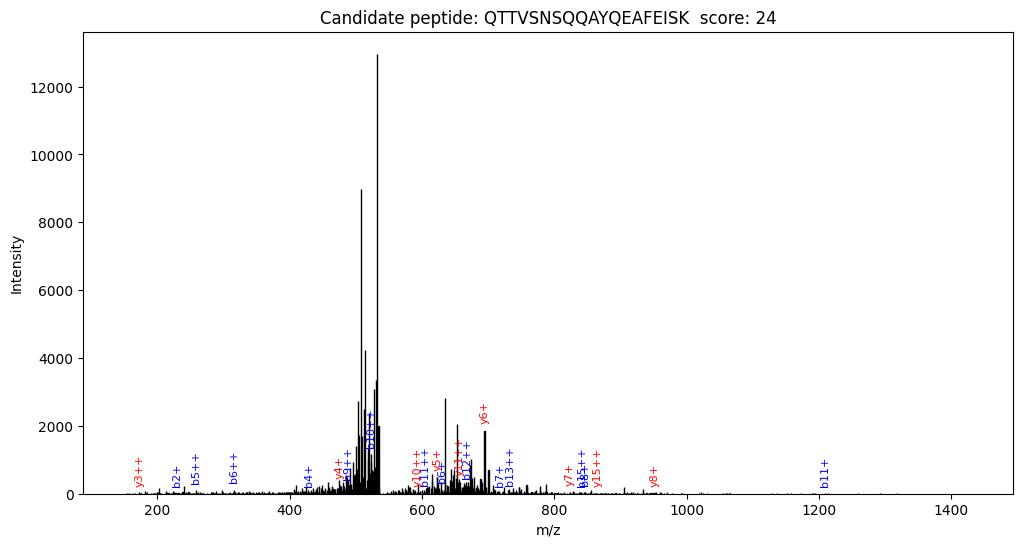

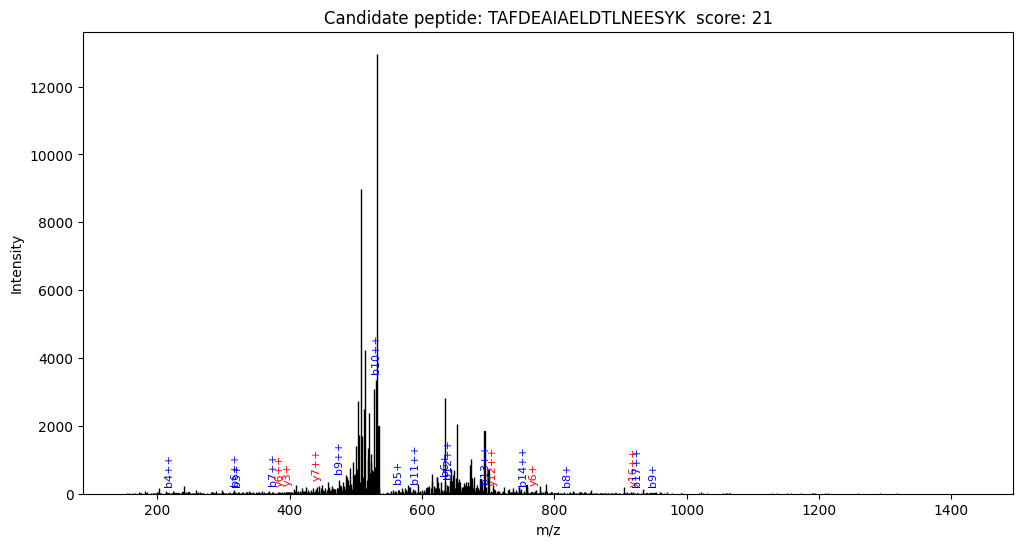

In [ ]:
def annotate_spectrum(observed_spectrum, theo_spectrum, alignment):
    """
    Annotate each peak in an observed MS/MS spectrum using fragment-ion labels
    from a matched theoretical spectrum.

    Parameters
    ----------
    observed_spectrum : MSSpectrum
        Experimental MS2 spectrum.

    theo_spectrum : MSSpectrum
        Theoretical spectrum containing fragment-ion labels in StringDataArrays.

    alignment : list of (int, int)
        Pairs of (theo_peak_index, exp_peak_index) returned by SpectrumAlignment.

    Returns
    -------
    annotated_peaks : list of (mz, intensity, annotation)
        One entry per experimental peak. Unmatched peaks receive an empty label.
    """

    # Start with empty annotations for all experimental peaks
    annotations = [""] * observed_spectrum.size()

    # Assign fragment-ion labels to matched experimental peaks
    for theo_idx, exp_idx in alignment:
        annotations[exp_idx] = theo_spectrum.getStringDataArrays()[0][theo_idx]

    # Build annotated peak list
    return [
        (
            observed_spectrum[i].getMZ(),
            observed_spectrum[i].getIntensity(),
            annotations[i]
        )
        for i in range(observed_spectrum.size())
    ]

def plot_annotated_spectrum(annotated_peaks, title="Annotated Spectrum"):
    """
    Plot an observed MS/MS spectrum and label matched b- and y-ions.

    Parameters
    ----------
    annotated_peaks : list of (mz, intensity, annotation)
        Output from annotate_spectrum.

    title : str
        Plot title.
    """

    mzs = [p[0] for p in annotated_peaks]
    intensities = [p[1] for p in annotated_peaks]

    plt.figure(figsize=(12, 6))
    plt.bar(mzs, intensities, width=0.1, color='lightgray', edgecolor='black')

    max_int = max(intensities) * 0.02  # vertical offset for labels

    # Add fragment-ion labels to matched peaks
    for mz, intensity, ann in annotated_peaks:
        ann_str = ann.decode() if isinstance(ann, bytes) else str(ann)

        if ann_str.startswith("b"):
            plt.text(mz, intensity + max_int, ann_str,
                     rotation=90, fontsize=8, ha='center',
                     color='blue')
        elif ann_str.startswith("y"):
            plt.text(mz, intensity + max_int, ann_str,
                     rotation=90, fontsize=8, ha='center',
                     color='red')

    plt.xlabel("m/z")
    plt.ylabel("Intensity")
    plt.title(title)
    plt.show()


for idx, row in candidate_df.iterrows():
    observed_spectrum = MS2[idx]

    # Iterate over all candidates and their corresponding data
    for peptide, theo_spectrum, alignment, score in zip(
            row["candidates"], row["theo_spectra"], row["alignment"], row["score"]):

        # Annotate experimental spectrum using matched theoretical peaks
        annotated_peaks = annotate_spectrum(
            observed_spectrum, theo_spectrum, alignment
        )

        # Plot annotated spectrum for visual inspection
        plot_annotated_spectrum(
            annotated_peaks,
            title=f"Candidate peptide: {peptide.toString()}  score: {score}"
        )
